# Assignment II: Discrete Event Simulation

This notebook shows some DES experiments which were needed for assignment II of the course Stoscastic Simulation at the UvA @2021. We start with creating some basis functions, which are used in the experiments afterwards.

In [1]:
# Import the apckages needed for the experiment
import numpy as np
import simpy
import matplotlib.pyplot as plt
import random
import pandas as pd
import seaborn as sns
from tqdm import trange
from scipy.stats import mannwhitneyu, shapiro
import scipy.stats as st

In [2]:
# SAVE and LOAD settings
TO_SAVE = False
TO_LOAD  = False

In [3]:
# Based on https://simpy.readthedocs.io/en/latest/examples/carwash.html

class ServerUsage(object):
    '''Object that represents the server'''
    def __init__(self, env, num_machines, mu, method):
        '''
        :param env: simpy environment
        :param num_machines: (C) number of counters
        :param mu: service method value
        :param method: method used to determine next customer
        '''
        self.env = env
        self.mu = mu
        if method == 'FIFO':
            # print("FIFO")
            self.machines = simpy.Resource(env, num_machines)
        elif method == 'prior':
            # print("PRIOR")
            self.machines = simpy.PriorityResource(env, num_machines)

    def service(self, customer):
        """Method to service a customer"""
        yield self.env.timeout(random.expovariate(self.mu))
        # print(f'Customer {customer} has been helped')

    def priorService(self, job_length, customer):
        """Method for priority service"""
        yield self.env.timeout(job_length)

    def det_service(self, customer):
        """Method for deterministic service"""
        yield self.env.timeout(1/self.mu)

    def fat_tail_service(self, customer):
        """Method for fat-tail service"""
        if random.random() > 0.25:
            _ = self.mu*0.8
        else:
            _ = self.mu*4
        
        yield self.env.timeout(random.expovariate(_))

def customer(env, name, Server, distribution):
    """Function for creating a customer
    
    :param env: Simpy environment
    :param name: name of the customer (iterator)
    :param Server: Simpy server
    :param distribution: Distribution for the service time
    """

    global waiting_times

    arrive = env.now
    # print(f'Customer {name} arrives at {arrive}')
    
    with Server.machines.request() as request:
        
        yield request

        # Save waiting times
        waiting_time = env.now - arrive
        waiting_times.append(waiting_time)

        if distribution == 'D':
            yield env.process(Server.det_service(name))
        elif distribution == 'F':
            yield env.process(Server.fat_tail_service(name))
        elif distribution == 'M':
            yield env.process(Server.service(name))   

        # print(f"Customer {name} leaves service at {env.now}")

def prior_customer(env, name, Server, job_length):
    """
    Customer that follows the priority rules. Same
    parameters as the normal customer
    """

    global waiting_times

    arrive = env.now
    # print(f'Customer {name} arrives at {arrive}')
    
    with Server.machines.request(priority=job_length) as request:
        
        yield request

        # Save waiting times
        waiting_time = env.now - arrive
        waiting_times.append(waiting_time)

        yield env.process(Server.priorService(job_length, name))   

        # print(f"Customer {name} leaves service at {env.now}")


def setup(env, num_machines, rho, mu, number_of_customers, method='FIFO', distribution='M'):

    """Method for setting up the environment"""

    ServerEnv = ServerUsage(env, num_machines, mu, method)
    lambda_ = rho * (mu * num_machines)

    # i = 0
    # env.process(customer(env, i, ServerEnv))
    # while True:
    #     yield env.timeout(random.expovariate(lambda_))
    #     i += 1
    #     env.process(customer(env, i, ServerEnv))

    if method == 'prior':
        if distribution != 'M':
            for i in range(number_of_customers):
                yield env.timeout(random.expovariate(lambda_))

                job_length = mu
                env.process(prior_customer(env, i, ServerEnv, job_length))

        else:   
            for i in range(number_of_customers):
                yield env.timeout(random.expovariate(lambda_))

                job_length = random.expovariate(ServerEnv.mu)
                env.process(prior_customer(env, i, ServerEnv, job_length))

    elif method == "FIFO":
        if distribution != 'M':
            for i in range(number_of_customers):
                yield env.timeout(random.expovariate(lambda_))

                env.process(customer(env, i, ServerEnv, distribution))
        else:
            for i in range(number_of_customers):
                yield env.timeout(random.expovariate(lambda_))
                env.process(customer(env, i, ServerEnv, distribution))

def checkShapiro(df):
    value = shapiro(df['MeanWaitingTime'])
    print(value)
    return value

## 1. Comparison of the multiple server configurations.

All experiments make use of the same configuration. They only differ in the c component, aka the number of servers is changed. 

First we set some global parameters:

Mu is given at 2.5, while Lambda is dependent on c.

In [4]:
RHO = 0.9
MU = 2.5
SIMULATIONS = 500

In [13]:
# loop over the different possibilities and save the data for analysis.
data = [[], [], []]
for j in [1, 2, 4]:
    for i in trange(SIMULATIONS):

        waiting_times = []
        service_times = []

        random.seed()
        env = simpy.Environment()
        env.process(setup(env, num_machines=j, rho=RHO, mu=MU, number_of_customers=5000))
        env.run()

        data[0].append(np.mean(waiting_times))
        data[1].append(len(waiting_times))
        data[2].append(j)

data = np.array(data).T
df_boxplot = pd.DataFrame(data, columns=['MeanWaitingTime', 'CustomerCount', 'Servers'])
df_boxplot['Servers'] = [f"{int(i)} Servers" for i in df_boxplot['Servers']]


100%|██████████| 500/500 [01:32<00:00,  5.42it/s]


In [14]:
# Save to csv for extra use
if TO_SAVE:
    df_boxplot.to_csv('../output/data/boxplot_data.csv')

# Load if needed
if TO_LOAD:
    df_boxplot = pd.read_csv('../output/data/boxplot_data.csv')

In [15]:
# Test for normality
for i in [1, 2, 4]:
    print('Shapiro: ', shapiro(df_boxplot.loc[df_boxplot['Servers'] == f"{i} Servers"]['MeanWaitingTime']))

    # Test for difference btween arrays
    for j in [1, 2, 4]:
        print(f'Mann-Whitney U {i}, {j}: ', mannwhitneyu(df_boxplot.loc[df_boxplot['Servers'] == f"{i} Servers"]['MeanWaitingTime'], 
                                               df_boxplot.loc[df_boxplot['Servers'] == f"{j} Servers"]['MeanWaitingTime']))

Shapiro:  ShapiroResult(statistic=0.875201940536499, pvalue=1.3092273523486644e-19)
Mann-Whitney U 1, 1:  MannwhitneyuResult(statistic=125000.0, pvalue=1.0)
Mann-Whitney U 1, 2:  MannwhitneyuResult(statistic=242761.0, pvalue=1.2360214610162258e-146)
Mann-Whitney U 1, 4:  MannwhitneyuResult(statistic=250000.0, pvalue=5.856242913498941e-165)
Shapiro:  ShapiroResult(statistic=0.8482794761657715, pvalue=1.642202619258967e-21)
Mann-Whitney U 2, 1:  MannwhitneyuResult(statistic=7239.0, pvalue=1.2360214610162258e-146)
Mann-Whitney U 2, 2:  MannwhitneyuResult(statistic=125000.0, pvalue=1.0)
Mann-Whitney U 2, 4:  MannwhitneyuResult(statistic=244479.0, pvalue=6.947041523841941e-151)
Shapiro:  ShapiroResult(statistic=0.9091994762420654, pvalue=1.0244304984691167e-16)
Mann-Whitney U 4, 1:  MannwhitneyuResult(statistic=0.0, pvalue=5.856242913498941e-165)
Mann-Whitney U 4, 2:  MannwhitneyuResult(statistic=5521.0, pvalue=6.947041523841941e-151)
Mann-Whitney U 4, 4:  MannwhitneyuResult(statistic=12500

Text(0.5, 0.98, 'Comparison of waiting times for different number of servers')

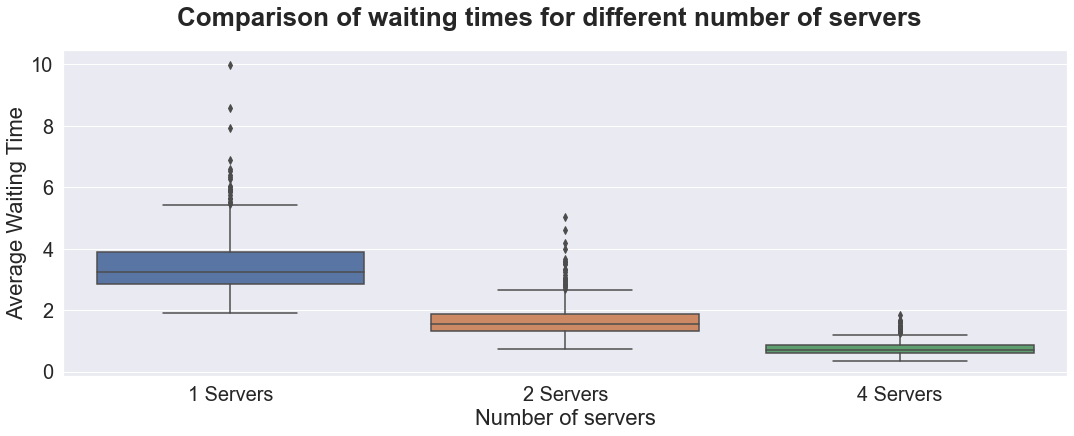

In [17]:
# Draw a boxplot
import seaborn as sns

sns.set(style='darkgrid')

fig, axis = plt.subplots(1, 1, figsize=(18, 6))
sns.boxplot(x='Servers', y='MeanWaitingTime', data=df_boxplot)
axis.tick_params('both', labelsize=20)
axis.set_xlabel('Number of servers', fontsize=22)
axis.set_ylabel('Average Waiting Time', fontsize=22)
fig.suptitle('Comparison of waiting times for different number of servers', fontsize=26, fontweight='bold')

In [18]:
# Check for standard statistics
for i in [1, 2, 4]:
    data = df_boxplot.loc[df_boxplot['Servers'] == f'{i} Servers']['MeanWaitingTime'].to_list()
    print(i, "\n Mean: ", np.mean(data))
    print("St.dev: ", np.std(data))
    mi, ma = st.t.interval(alpha=0.95, df=len(data) - 1, scale=st.sem(data))
    print("Conf. int", np.mean(data) + mi, np.mean(data) + ma)


1 
 Mean:  3.486086736383186
St.dev:  0.9789541873617478
Conf. int 3.3999844195634563 3.5721890532029152
2 
 Mean:  1.6785978779433863
St.dev:  0.537921094659569
Conf. int 1.631285906541318 1.7259098493454545
4 
 Mean:  0.7588702866818501
St.dev:  0.2254836670838121
Conf. int 0.7390382389807756 0.7787023343829246


Check how the statistics depend on rho

In [19]:
RHO = 0.9
MU = 2.5
SIMULATIONS = 50

In [20]:
# Save the data 
rhos = np.linspace(0, 1, 101)[1:]
data = [[],[],[],[]]
for z in trange(len(rhos)):
    for j in [1, 2, 4]:
        for i in range(SIMULATIONS):

            waiting_times = []

            random.seed()
            env = simpy.Environment()
            env.process(setup(env, num_machines=j, rho=rhos[z], mu=MU, number_of_customers=500))
            env.run()

            data[0].append(np.mean(waiting_times))
            data[1].append(len(waiting_times))
            data[2].append(j)
            data[3].append(rhos[z])

data = np.array(data).T
df_variance = pd.DataFrame(data, columns=['MeanWaitingTime', 'CustomerCount', 'Servers', 'Rho'])

100%|██████████| 100/100 [04:57<00:00,  2.97s/it]


In [21]:
# Save df
if TO_SAVE:
    df_variance.to_csv('../output/data/variance_data.csv')

# Read from csv
if TO_LOAD:
    df_variance = pd.read_csv('../output/data/variance_data.csv')

(0.0, 1.0)

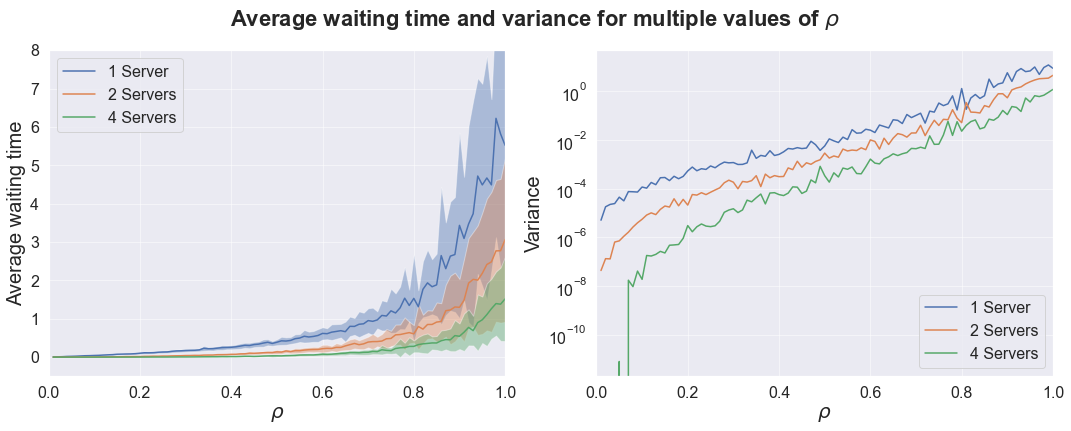

In [22]:
# Draw figure
fig, axis = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle('Average waiting time and variance for multiple values of $\\rho$', fontsize=22, fontweight='bold')
labels = ['1 Server', '2 Servers', '4 Servers']

sub1 = df_variance.loc[df_variance['Servers'] == 1]
sub2 = df_variance.loc[df_variance['Servers'] == 2]
sub4 = df_variance.loc[df_variance['Servers'] == 4]


quantiles = [[[np.quantile(sub1.loc[sub1['Rho'] == i]['MeanWaitingTime'], 0.25),
               np.quantile(sub1.loc[sub1['Rho'] == i]['MeanWaitingTime'], 0.75)] for i in sub1['Rho'].unique()], 
             [[np.quantile(sub2.loc[sub2['Rho'] == i]['MeanWaitingTime'], 0.25),
               np.quantile(sub2.loc[sub2['Rho'] == i]['MeanWaitingTime'], 0.75)] for i in sub1['Rho'].unique()],
             [[np.quantile(sub4.loc[sub4['Rho'] == i]['MeanWaitingTime'], 0.25),
               np.quantile(sub4.loc[sub4['Rho'] == i]['MeanWaitingTime'], 0.75)] for i in sub1['Rho'].unique()]]

means = [[np.mean(sub1.loc[sub1['Rho'] == i]['MeanWaitingTime']) for i in sub1['Rho'].unique()], 
         [np.mean(sub2.loc[sub2['Rho'] == i]['MeanWaitingTime']) for i in sub1['Rho'].unique()], 
         [np.mean(sub4.loc[sub4['Rho'] == i]['MeanWaitingTime']) for i in sub1['Rho'].unique()]]

variances = [[np.var(sub1.loc[sub1['Rho'] == i]['MeanWaitingTime']) for i in sub1['Rho'].unique()],
             [np.var(sub2.loc[sub2['Rho'] == i]['MeanWaitingTime']) for i in sub1['Rho'].unique()],
             [np.var(sub4.loc[sub4['Rho'] == i]['MeanWaitingTime']) for i in sub1['Rho'].unique()]]

# axis[0].scatter(sub1['Rho'], sub1['MeanWaitingTime'])
for i in range(len(variances)):
    axis[0].plot(sub1['Rho'].unique(), means[i], label=labels[i])
    axis[0].fill_between(sub1['Rho'].unique(), means[i] - np.sqrt(np.array(variances[i])), means[i] + np.sqrt(np.array(variances[i])), alpha=0.4)

axis[0].legend(loc='upper left', fontsize=16)
axis[0].tick_params('both', labelsize=16)
axis[0].set_xlabel('$\\rho$', fontsize=20)
axis[0].set_ylabel('Average waiting time', fontsize=20)
axis[0].grid(alpha=0.5)
axis[0].set_xlim(0,1)
axis[0].set_ylim(-0.5, 8)


for i in range(len(variances)):
    axis[1].plot(sub1['Rho'].unique(), variances[i], label=labels[i])

axis[1].set_yscale('log')
axis[1].set_xlabel('$\\rho$', fontsize=20)
axis[1].set_ylabel('Variance', fontsize=20)
axis[1].tick_params('both', labelsize=16)
axis[1].legend(fontsize=16, loc='lower right')
axis[1].grid(alpha=0.5)
axis[1].set_xlim(0,1)


## 2. Compare results with shortest job first

In [57]:
RHO = 0.9
MU = 2.5
SIMULATIONS = 500

In [65]:
# Save the data 
data = [[], [], [], []]
for z in ['prior', 'FIFO']:
    for j in [1, 2, 4]:
        for i in trange(SIMULATIONS):

            waiting_times = []
            service_times = []

            random.seed()
            env = simpy.Environment()
            env.process(setup(env, num_machines=j, rho=RHO, mu=MU, number_of_customers=5000, method=z))
            env.run()

            data[0].append(np.mean(waiting_times))
            data[1].append(len(waiting_times))
            data[2].append(j)
            data[3].append(z)

df_comparison = pd.DataFrame(data).T
df_comparison.columns = ['MeanWaitingTime', 'CustomerCount', 'Servers', 'Method']

100%|██████████| 500/500 [01:28<00:00,  5.64it/s]


In [66]:
# Save new dataframe
if TO_SAVE:
    df_comparison.to_csv('../output/data/ServiceMethodPrior.csv', index=False)

# Load again
if TO_LOAD:
    df_comparison = pd.read_csv('../output/data/ServiceMethodPrior.csv')

In [71]:
if (TO_SAVE == False) & (TO_LOAD == False):
    df_comparison.to_csv('temp.csv')
    df_comparison = pd.read_csv('temp.csv')
    os.remove('temp.csv')

# Test for normality
for i in [1, 2, 4]:
    for i2 in ['prior', 'FIFO']:
        print('Shapiro: ', shapiro(df_comparison.loc[(df_comparison['Servers'] == i) &
                                                     (df_comparison['Method'] == i2)]['MeanWaitingTime']))

    # Test for difference btween arrays
    for j in [1, 2, 4]:
        for j2 in ['prior', 'FIFO']:
            print(f'Mann-Whitney U {i}, {i2}: {j}, {j2}: ', mannwhitneyu(df_comparison.loc[(df_comparison['Servers'] == i) &
                                                                               (df_comparison['Method'] == i2)]['MeanWaitingTime'], 
                                                             df_comparison.loc[(df_comparison['Servers'] == j) &
                                                                               (df_comparison['Method'] == j2)]['MeanWaitingTime']))

Shapiro:  ShapiroResult(statistic=0.9161719679832458, pvalue=4.989116703556435e-16)
Shapiro:  ShapiroResult(statistic=0.9173967838287354, pvalue=6.652100724065539e-16)
Mann-Whitney U 1, FIFO: 1, prior:  MannwhitneyuResult(statistic=249917.0, pvalue=9.635999706584022e-165)
Mann-Whitney U 1, FIFO: 1, FIFO:  MannwhitneyuResult(statistic=125000.0, pvalue=1.0)
Mann-Whitney U 1, FIFO: 2, prior:  MannwhitneyuResult(statistic=250000.0, pvalue=5.856242913498941e-165)
Mann-Whitney U 1, FIFO: 2, FIFO:  MannwhitneyuResult(statistic=242653.0, pvalue=2.2759406333342086e-146)
Mann-Whitney U 1, FIFO: 4, prior:  MannwhitneyuResult(statistic=250000.0, pvalue=5.856242913498941e-165)
Mann-Whitney U 1, FIFO: 4, FIFO:  MannwhitneyuResult(statistic=249998.0, pvalue=5.92696384552083e-165)
Shapiro:  ShapiroResult(statistic=0.8962863683700562, pvalue=6.7797873674438786e-18)
Shapiro:  ShapiroResult(statistic=0.857184112071991, pvalue=6.521256073646522e-21)
Mann-Whitney U 2, FIFO: 1, prior:  MannwhitneyuResult(st

In [72]:
RHO = 0.9
MU = 2.5
SIMULATIONS = 50

In [73]:
# Save the data 
rhos = np.linspace(0, 1, 101)[1:]
data = [[],[],[],[],[]]
for z in trange(len(rhos)):
    for w in ['prior', 'FIFO']:
        for j in [1, 2, 4]:
            for i in range(SIMULATIONS):

                waiting_times = []

                random.seed()
                env = simpy.Environment()
                env.process(setup(env, num_machines=j, rho=rhos[z], mu=MU, number_of_customers=500, method=w))
                env.run()

                data[0].append(np.mean(waiting_times))
                data[1].append(len(waiting_times))
                data[2].append(j)
                data[3].append(rhos[z])
                data[4].append(w)

data = np.array(data).T
df_variance_methods = pd.DataFrame(data, columns=['MeanWaitingTime', 'CustomerCount', 'Servers', 'Rho', 'Method'])

100%|██████████| 100/100 [10:04<00:00,  6.04s/it]


In [82]:
# Save new dataframe
if TO_SAVE:
    df_variance_methods.to_csv('../output/data/varianceMethod.csv')

# Load again
if TO_LOAD:
    df_variance_methods = pd.read_csv('../output/data/varianceMethod.csv')

if (TO_SAVE == False) & (TO_LOAD == False):
    df_variance_methods.to_csv('temp.csv')
    df_variance_methods = pd.read_csv('temp.csv')
    os.remove('temp.csv')

Text(0.5, 0.98, 'Average waiting time for FIFO and priority')

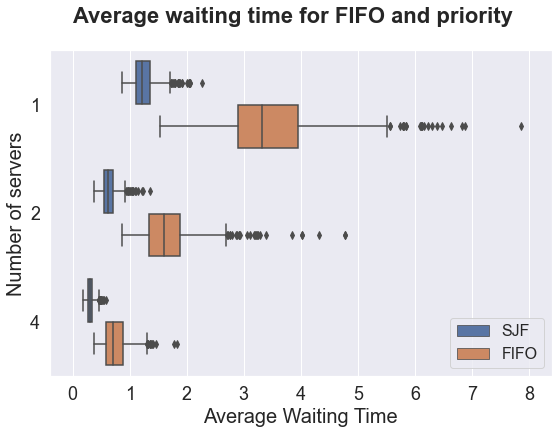

In [75]:
# Draw figure
fig, axis = plt.subplots(figsize=(9,6))
sns.boxplot(x='MeanWaitingTime', y='Servers', hue='Method', data=df_comparison, orient='h', ax=axis)
# sns.boxplot(x='Servers', y='MeanWaitingTime', data=new_df.loc[new_df['Method'] == 'FIFO'])
axis.tick_params('both', labelsize=18)
axis.set_xlim(-0.4, 8.4)
axis.set_ylabel('Number of servers', fontsize=20)
axis.set_xlabel('Average Waiting Time', fontsize=20)
h , l = axis.get_legend_handles_labels()
axis.legend(fontsize=16, loc='lower right', handles=h, labels=['SJF', 'FIFO'])
fig.suptitle('Average waiting time for FIFO and priority', fontsize=22, fontweight='bold')

(-0.05, 1.05)

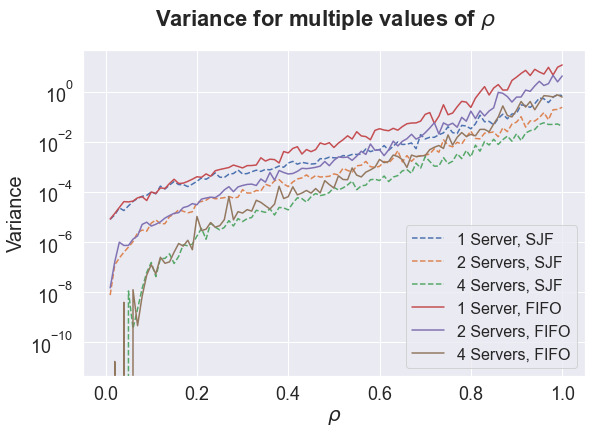

In [83]:
# Draw figure
fig, axis = plt.subplots(figsize=(9, 6))
fig.suptitle('Variance for multiple values of $\\rho$', fontsize=22, fontweight='bold')
labels = ['1 Server', '2 Servers', '4 Servers']

for method in ['prior', 'FIFO']:
    temp_df = df_variance_methods.loc[df_variance_methods['Method'] == method]
    # print(temp_df)

    # print(temp_df['Servers'])
    sub1 = temp_df.loc[temp_df['Servers'] == 1]
    sub2 = temp_df.loc[temp_df['Servers'] == 2]
    sub4 = temp_df.loc[temp_df['Servers'] == 4]

    variances = [[np.var(sub1.loc[sub1['Rho'] == i]['MeanWaitingTime']) for i in sub1['Rho'].unique()],
                [np.var(sub2.loc[sub2['Rho'] == i]['MeanWaitingTime']) for i in sub1['Rho'].unique()],
                [np.var(sub4.loc[sub4['Rho'] == i]['MeanWaitingTime']) for i in sub1['Rho'].unique()]]

    for i in range(len(variances)):
        if method == 'prior':
            axis.plot(sub1['Rho'].unique(), variances[i], label=f"{labels[i]}, SJF", linestyle='dashed')
        else:
            axis.plot(sub1['Rho'].unique(), variances[i], label=f"{labels[i]}, FIFO")
            

# axis[0].legend(loc='upper left', fontsize=16)
# axis[0].tick_params('both', labelsize=16)
# axis[0].set_xlabel('$\\rho$', fontsize=20)
# axis[0].set_ylabel('Average waiting time', fontsize=20)
# axis[0].grid(alpha=0.5)
# axis[0].set_xlim(0,1)

# sns.boxplot(x='MeanWaitingTime', y='Servers', hue='Method', data=df_comparison, orient='h', ax=axis[0])
# # sns.boxplot(x='Servers', y='MeanWaitingTime', data=new_df.loc[new_df['Method'] == 'FIFO'])
# axis[0].tick_params('both', labelsize=20)
# # axis.set_ylim(0, 9)
# axis[0].set_xlabel('Number of servers', fontsize=22)
# axis[0].set_ylabel('Average Waiting Time', fontsize=22)
# axis[0].legend(fontsize=20, loc='lower right')
# fig.suptitle('Comparison of waiting times for different number of servers', fontsize=26, fontweight='bold')

axis.set_yscale('log')
axis.set_xlabel('$\\rho$', fontsize=20)
axis.set_ylabel('Variance', fontsize=20)
axis.tick_params('both', labelsize=18)
axis.legend(fontsize=16, loc='lower right')
axis.set_xlim(-0.05,1.05)


In [77]:
RHO = 0.9
MU = 2.5
SIMULATIONS = 500

In [78]:
# Save the data 
data = [[], [], [], []]
for z in ['F', 'M', 'D']:
    for j in [1, 2, 4]:
        for i in trange(SIMULATIONS):

            waiting_times = []

            random.seed()
            env = simpy.Environment()
            env.process(setup(env, num_machines=j, rho=RHO, mu=MU, 
                              number_of_customers=5000, method='FIFO', distribution=z))
            env.run()

            data[0].append(np.mean(waiting_times))
            data[1].append(len(waiting_times))
            data[2].append(j)
            data[3].append(z)

data = np.array(data).T
df_comparisonDeterministic = pd.DataFrame(data, columns=['MeanWaitingTime', 'CustomerCount', 'Servers', 'b_distribution'])

100%|██████████| 500/500 [01:25<00:00,  5.83it/s]


In [84]:
# Save df
if TO_SAVE:
    df_comparisonDeterministic.to_csv('../output/data/ComparisonDeterministic.csv')

# Load df
if TO_LOAD:
    df_comparisonDeterministic = pd.read_csv('../output/data/ComparisonDeterministic.csv')

if (TO_SAVE == False) & (TO_LOAD == False):
    df_comparisonDeterministic.to_csv('temp.csv')
    df_comparisonDeterministic = pd.read_csv('temp.csv')
    os.remove('temp.csv')

In [85]:
# Test for normality
for i in [1, 2, 4]:
    for i2 in ['F', 'M', 'D']:
        print('Shapiro: ', shapiro(df_comparisonDeterministic.loc[(df_comparisonDeterministic['Servers'] == i) &
                                                     (df_comparisonDeterministic['b_distribution'] == i2)]['MeanWaitingTime']))

    # Test for difference btween arrays
    for j in [1, 2, 4]:
        for j2 in ['F', 'M', 'D']:
            print(f'Mann-Whitney U {i}, {i2}: {j}, {j2}: ', mannwhitneyu(df_comparisonDeterministic.loc[(df_comparisonDeterministic['Servers'] == i) &
                                                                                                        (df_comparisonDeterministic['b_distribution'] == i2)]['MeanWaitingTime'], 
                                                                        df_comparisonDeterministic.loc[(df_comparisonDeterministic['Servers'] == j) &
                                                                                                       (df_comparisonDeterministic['b_distribution'] == j2)]['MeanWaitingTime']))

Shapiro:  ShapiroResult(statistic=0.9071954488754272, pvalue=6.605073587182878e-17)
Shapiro:  ShapiroResult(statistic=0.8742341995239258, pvalue=1.1056463128780588e-19)
Shapiro:  ShapiroResult(statistic=0.9263831377029419, pvalue=6.0546702810378335e-15)
Mann-Whitney U 1, D: 1, F:  MannwhitneyuResult(statistic=1066.0, pvalue=3.423400006121268e-162)
Mann-Whitney U 1, D: 1, M:  MannwhitneyuResult(statistic=3837.0, pvalue=4.131619634675841e-155)
Mann-Whitney U 1, D: 1, D:  MannwhitneyuResult(statistic=125000.0, pvalue=1.0)
Mann-Whitney U 1, D: 2, F:  MannwhitneyuResult(statistic=99397.0, pvalue=2.0654937128584838e-08)
Mann-Whitney U 1, D: 2, M:  MannwhitneyuResult(statistic=152178.0, pvalue=2.6599331001775044e-09)
Mann-Whitney U 1, D: 2, D:  MannwhitneyuResult(statistic=248646.0, pvalue=1.8963402624655484e-161)
Mann-Whitney U 1, D: 4, F:  MannwhitneyuResult(statistic=242260.0, pvalue=2.0888647645924746e-145)
Mann-Whitney U 1, D: 4, M:  MannwhitneyuResult(statistic=246396.0, pvalue=1.063669

Text(0.5, 0.98, 'Comparison of waiting times for different number of servers')

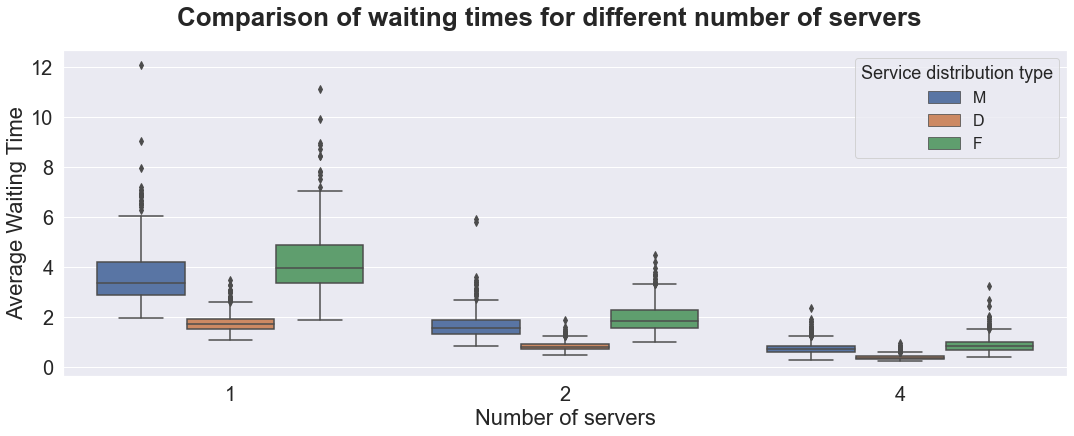

In [86]:
# Draw figure
sns.set(style='darkgrid')

fig, axis = plt.subplots(1, 1, figsize=(18, 6))
sns.boxplot(x='Servers', y='MeanWaitingTime', data=df_comparisonDeterministic, hue='b_distribution', width=0.8, hue_order=['M', 'D', 'F'])
axis.tick_params('both', labelsize=20)
axis.set_xlabel('Number of servers', fontsize=22)
axis.set_ylabel('Average Waiting Time', fontsize=22)
# axis.legend(title='Dsitrbution type', title_fontproperties={'fontsize':20}, fontsize=20)
axis.legend(title='Service distribution type', title_fontsize=18, fontsize=16)
fig.suptitle('Comparison of waiting times for different number of servers', fontsize=26, fontweight='bold')